# Project 4: Fuel Monitoring System Design
>**Date Created**: 21 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sympy as smp
from scipy.linalg import expm, solve_discrete_are

plt.rcParams["text.usetex"] = True
plt.rcParams["legend.edgecolor"] = "black"

In [296]:
# Read in data and label columns
data = r"fuel_data.csv"
df = pd.read_csv(data, header=None)
columnMapper = dict(
    zip(
        df.columns.values,
        ["t", "u_k", "y_k", "f_k", "b_k"],
    )
)
df = df.rename(columns=columnMapper)
df = df.fillna(22)
display(df.head())
z = df[["u_k", "y_k"]].to_numpy()

,t,u_k,y_k,f_k,b_k
0,0.0,8.712638,22.000000,3200.000000,0.050000
1,0.5,13.283346,22.450033,3195.676728,0.099930
2,1.0,3.195561,21.643693,3189.054264,0.005879
3,1.5,8.187671,19.818694,3187.447473,-0.038837
4,2.0,13.939558,19.719150,3183.364968,0.013155


In [327]:
Aline = 1  # cm**2
dt = 0.5  # sec
Atank = 150  # cm**2
Q = np.diag([Aline**2 * dt**2 * 0.1**2, 0.1**2])
R = 1**2
x0 = np.array([3200, 0])
P0 = np.diag([10**2, 0.1**2])

F = np.array([[1, Aline * dt], [0, 1]])
G = np.array([-Aline * dt, 0])
H = np.array([1 / Atank, 0])

## Part B

In [328]:
def predict(u, x, P, F, G, Q):
    xhat_k_km1 = np.dot(F, x) + np.dot(G, u)
    Phat_k_km1 = F @ P @ F.T + Q
    return xhat_k_km1, Phat_k_km1

In [329]:
def update(z, x, P, H, R):
    x_in = x
    z_in = z
    P_in = P

    yhat = z_in - np.dot(H, x_in)
    S = np.dot(np.dot(H, P_in), H.T) + R
    K = np.dot(np.dot(P_in, H.T), 1 / S)
    x_out = x_in + np.dot(K, yhat)
    P_out = P_in - np.dot(np.dot(K, H), P_in)
    return x_out, P_out, K

In [330]:
n = len(df.index)
res = np.zeros((n, 2))
covs = np.zeros((2, 2, n))
Ks = np.zeros((n,2))
t = np.linspace(0,300, n)
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        covs[:, :, k] = P
        continue
    u = df.loc[k - 1, "u_k"]
    z = df[["u_k", "y_k"]].to_numpy()[k][1]
    xp, Pp = predict(u, x, P, F, G, Q)
    xu, Pu, K = update(z, xp, Pp, H, R)
    x = xu
    P = Pu
    res[k] = x
    covs[:, :, k] = P
    Ks[k] = K

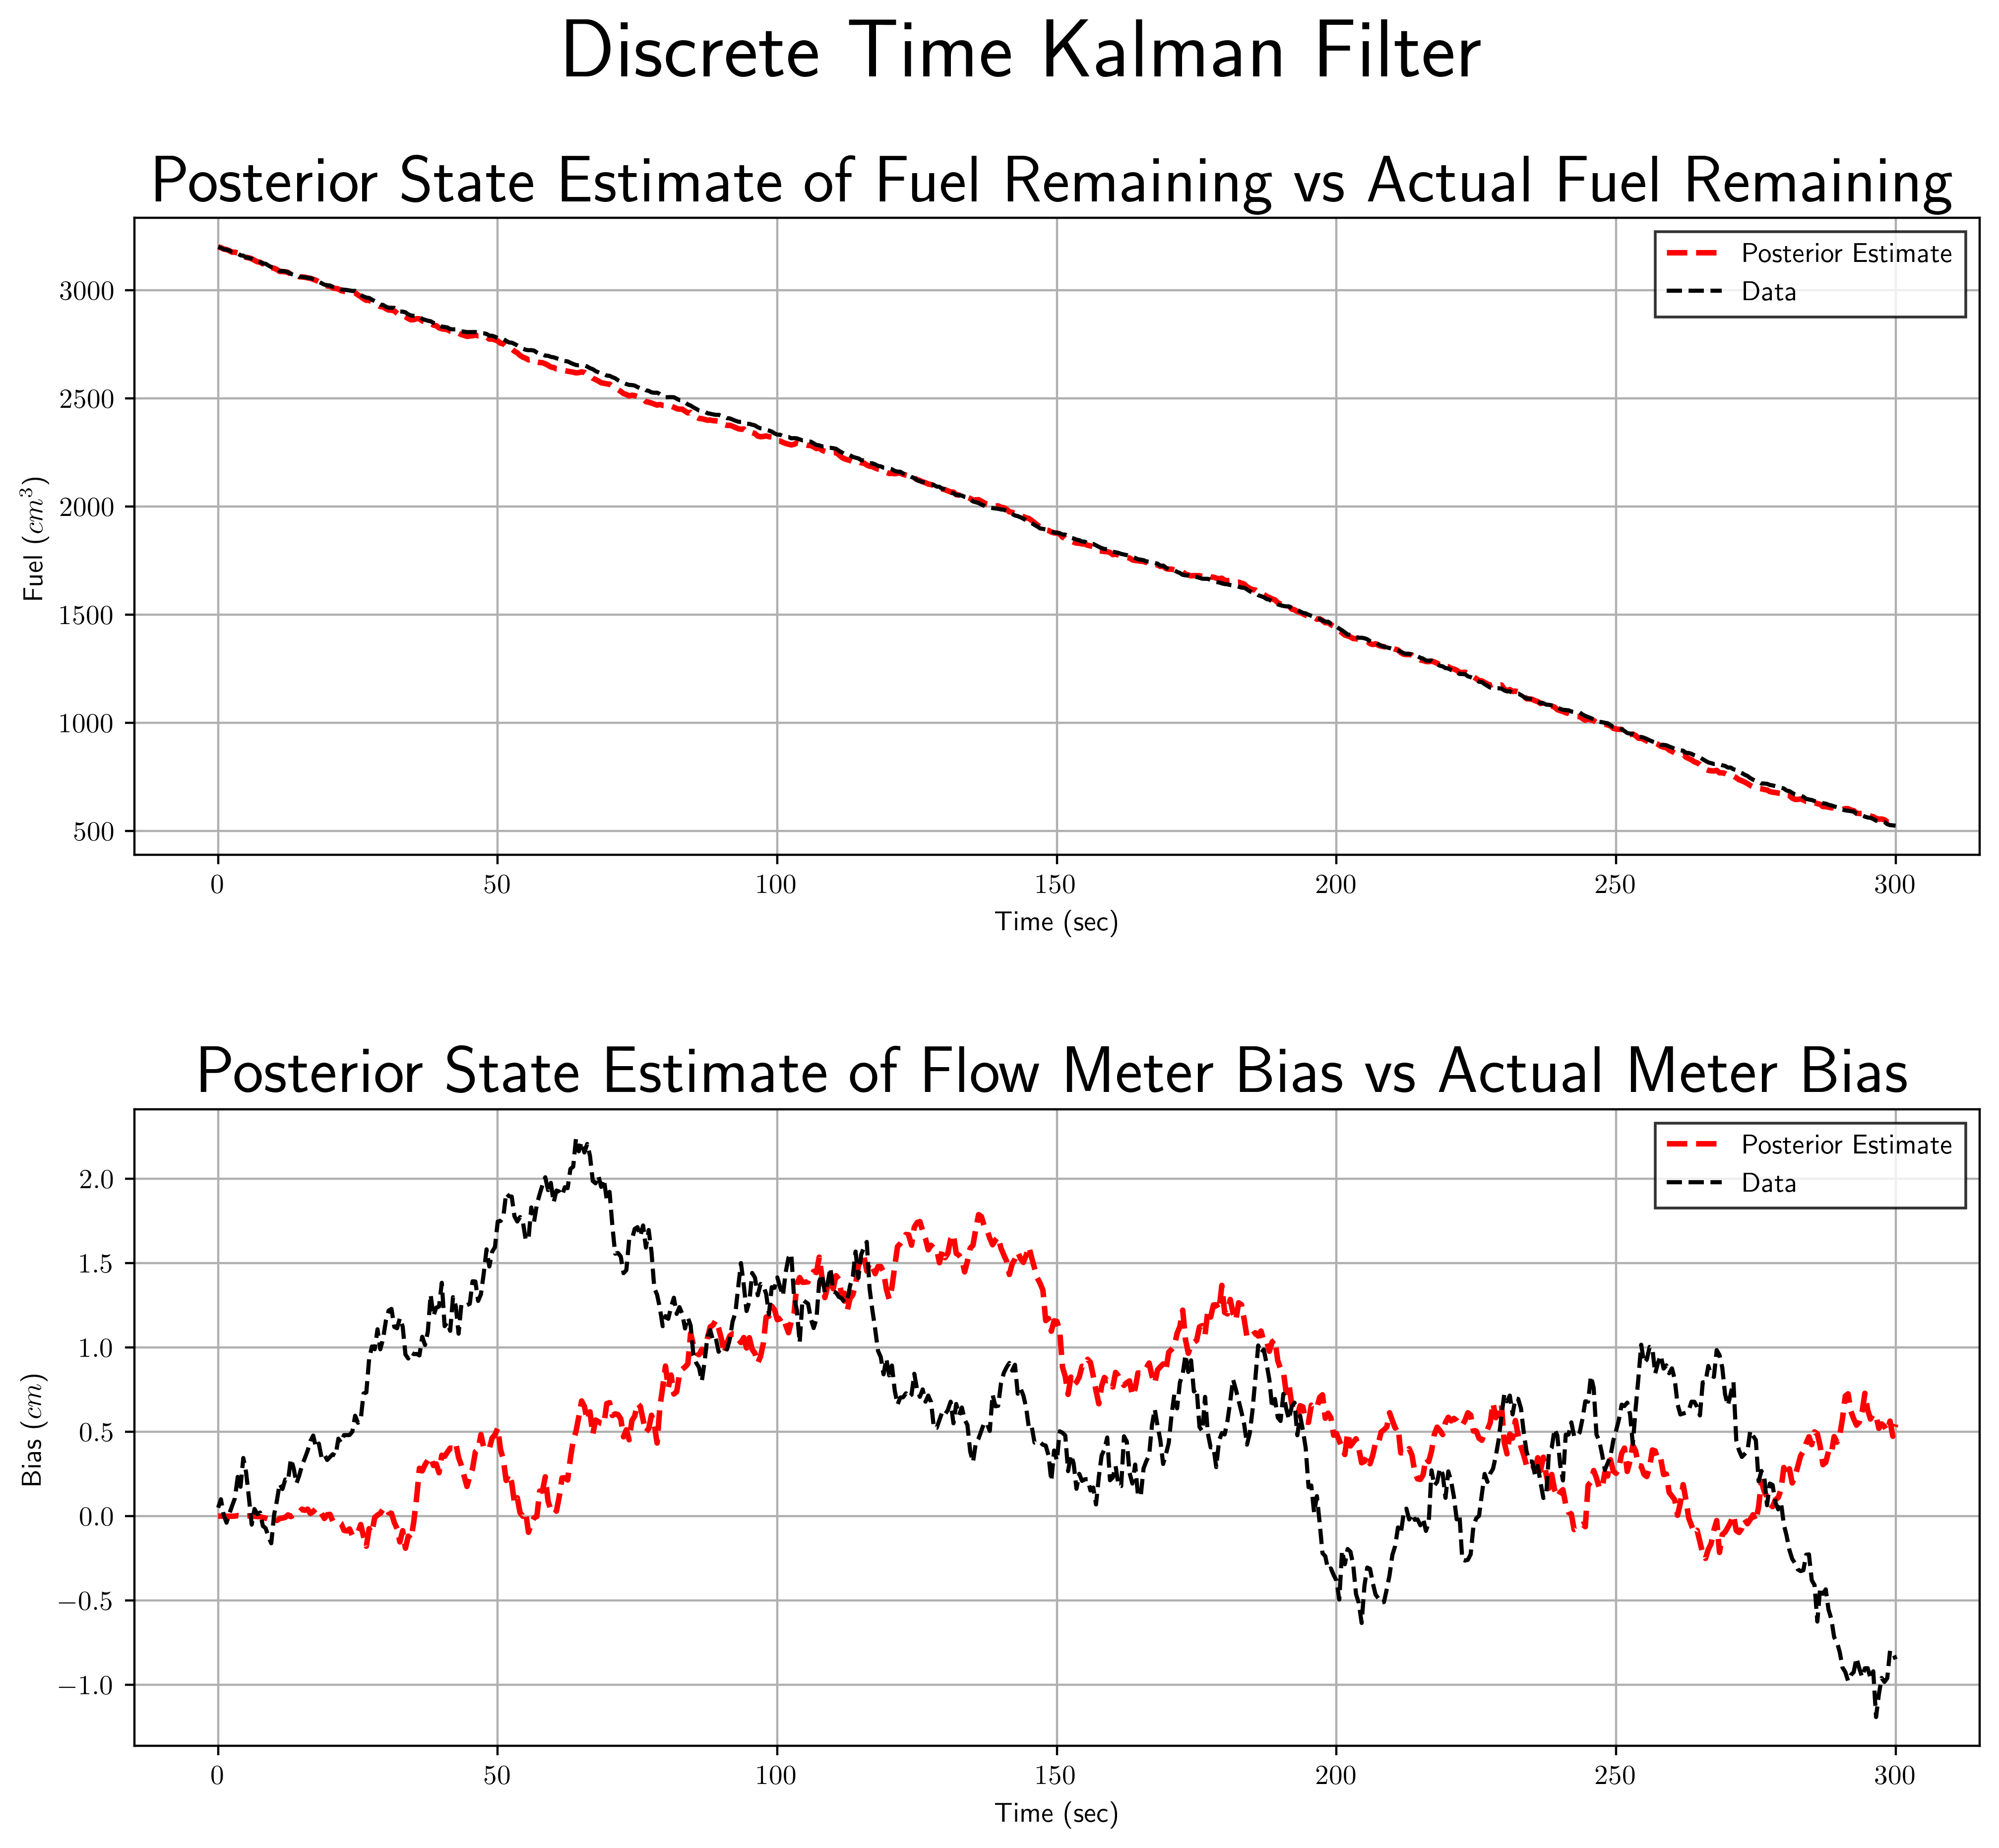

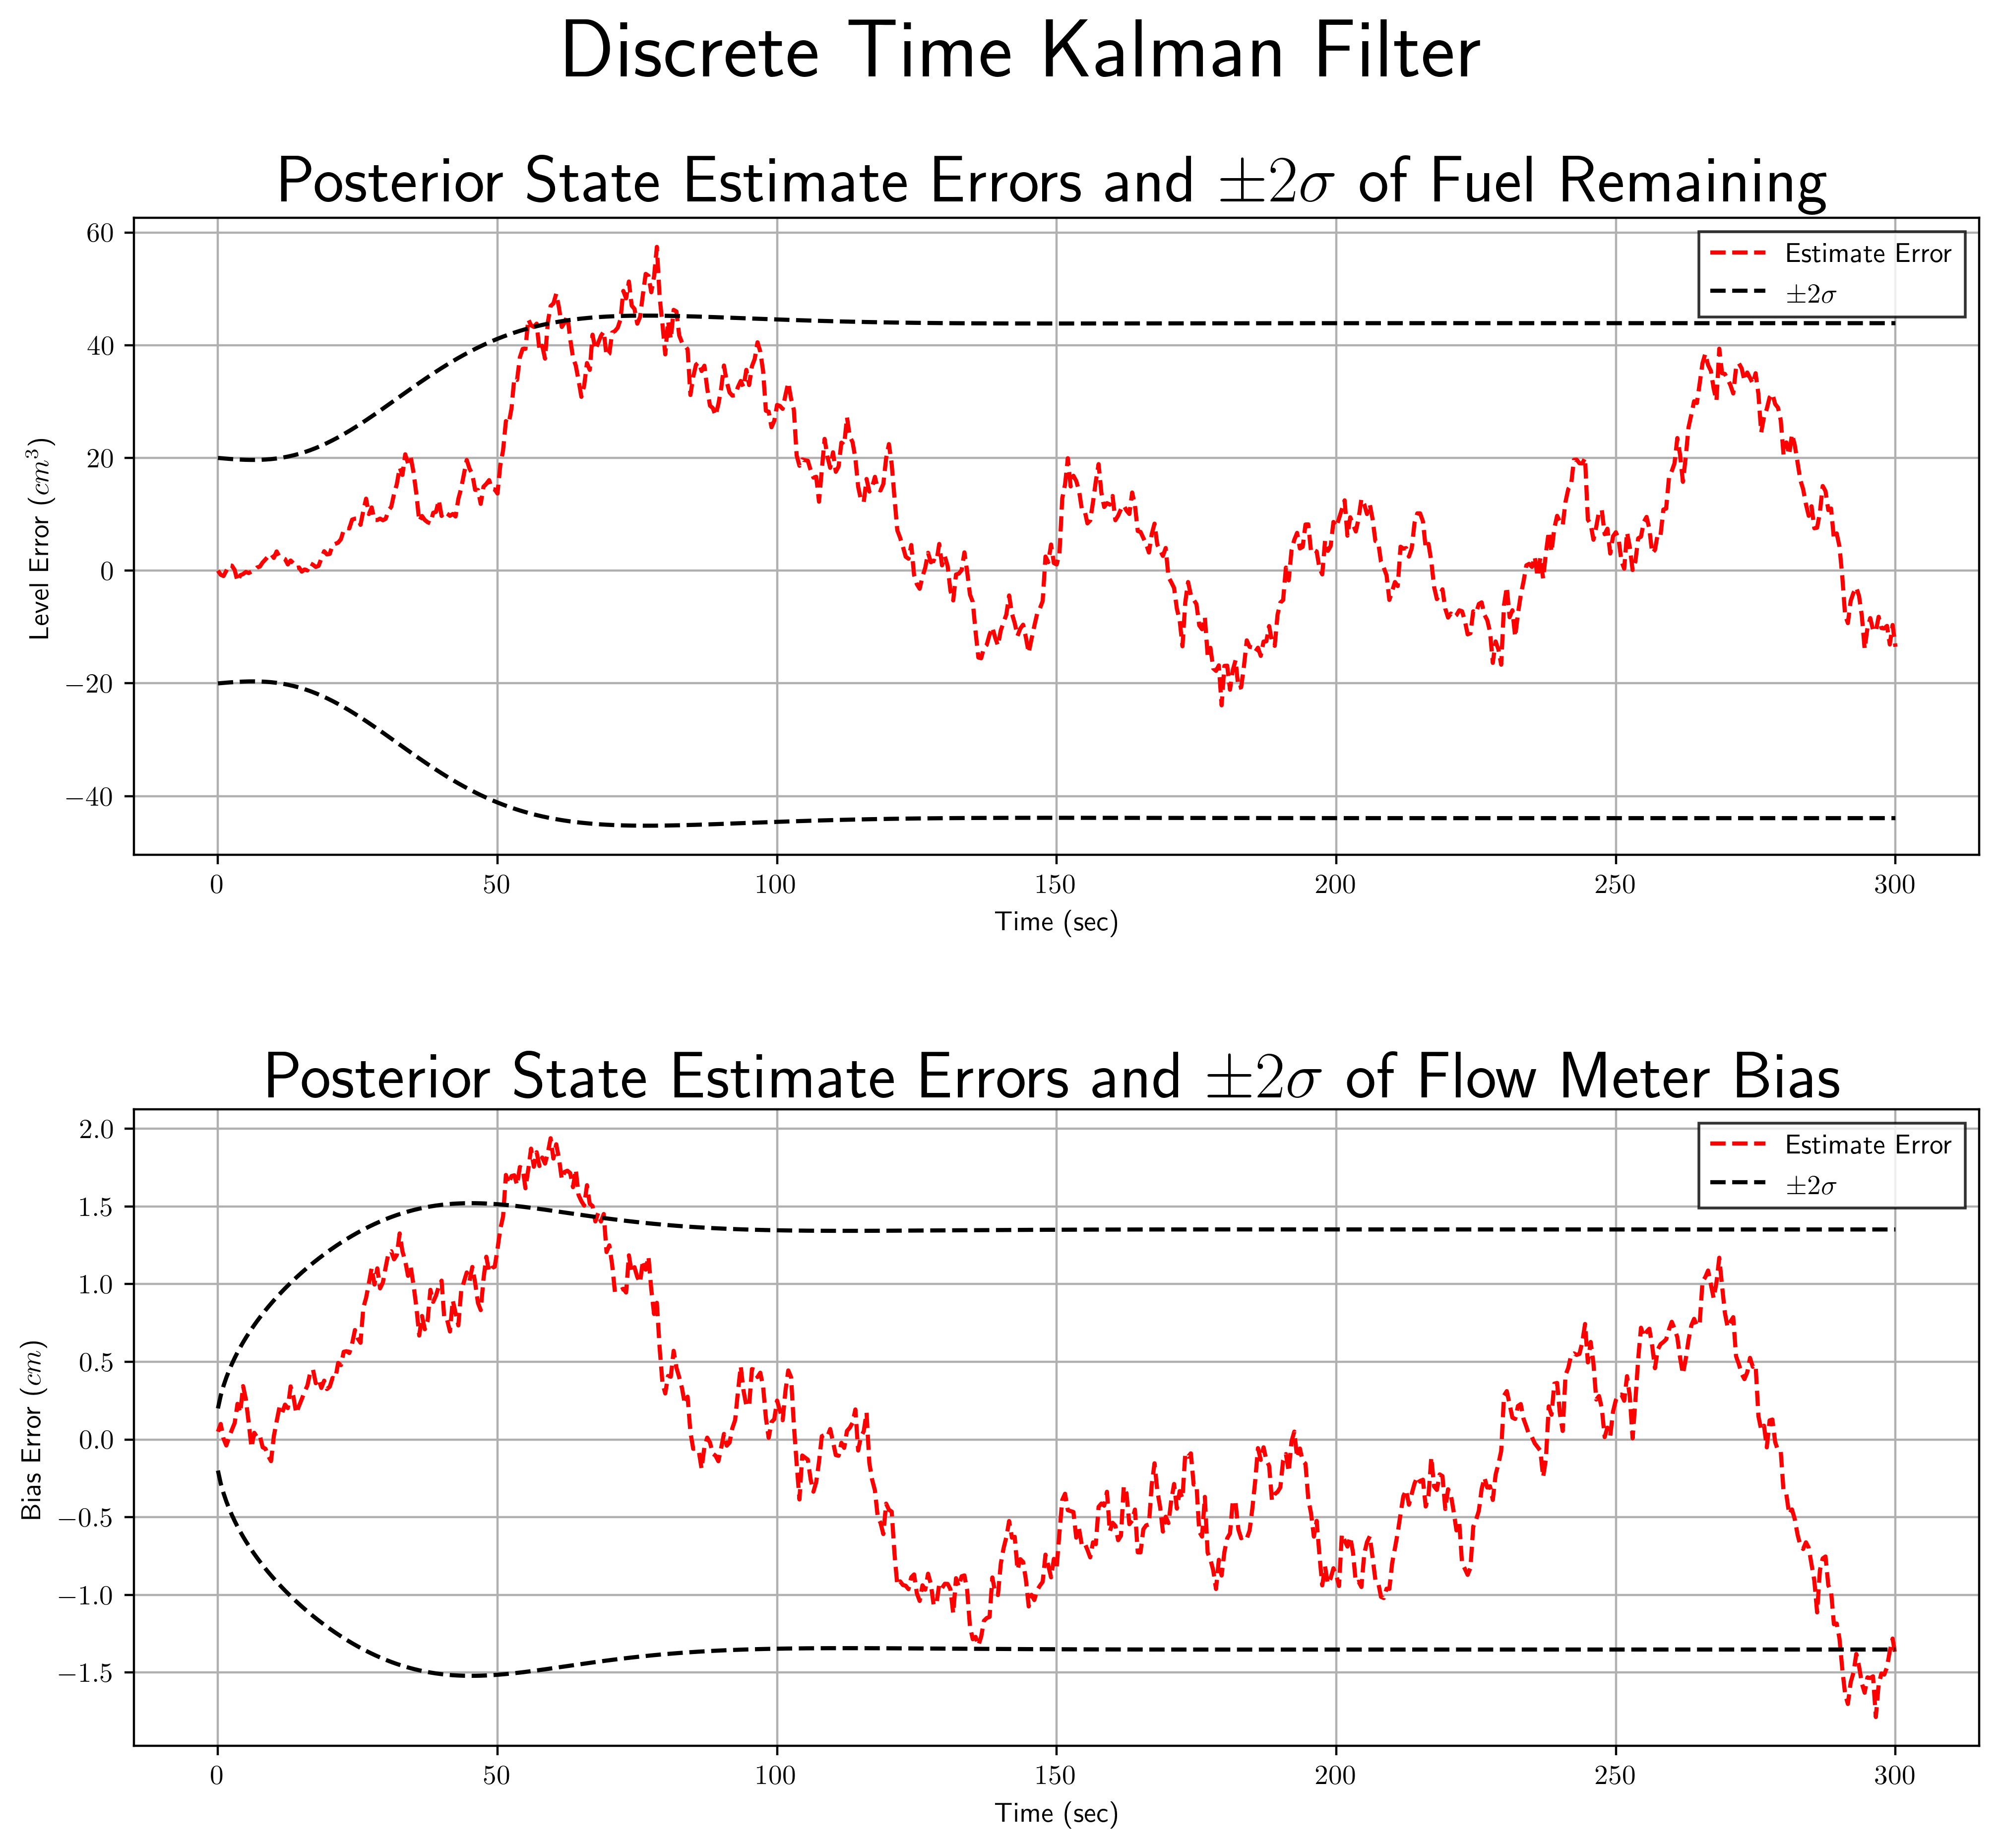

In [331]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle('Discrete Time Kalman Filter',fontsize=30)

ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, res[:, 0], "r--", lw=2, label="Posterior Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, res[:, 1], "r--", lw=2, label="Posterior Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("2a.png")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle('Discrete Time Kalman Filter',fontsize=30)

diffs = df[["f_k", "b_k"]].to_numpy() - res
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, 2 * np.sqrt(covs[0, 0, :]), "k--", label="$\pm 2\sigma$")
ax1.plot(t, -2 * np.sqrt(covs[0, 0, :]), "k--")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, 2 * np.sqrt(covs[1, 1, :]), "k--", label="$\pm 2\sigma$")
ax2.plot(t, -2 * np.sqrt(covs[1, 1, :]), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("2b.png")

## Part A

In [332]:
def predict_update(x, z, u, F, G, P, K, H):
    xhat_k_km1 = np.dot(F, x) + np.dot(G, u)
    yhat = z - np.dot(H, xhat_k_km1)
    x_out = xhat_k_km1 + np.dot(K, yhat)
    return x_out

In [333]:
res_a = np.zeros((n, 2))
P_inf = covs[:,:,-1]
K_inf = Ks[-1]
t = np.linspace(0,300,n)
for k in range(n):
    if k == 0:
        x = x0
        res_a[k] = x
        continue
    u = df.loc[k - 1, "u_k"]
    z = df[["u_k", "y_k"]].to_numpy()[k][1]
    xu = predict_update(x, z, u, F, G, P_inf, K_inf, H)
    x = xu
    res_a[k] = x

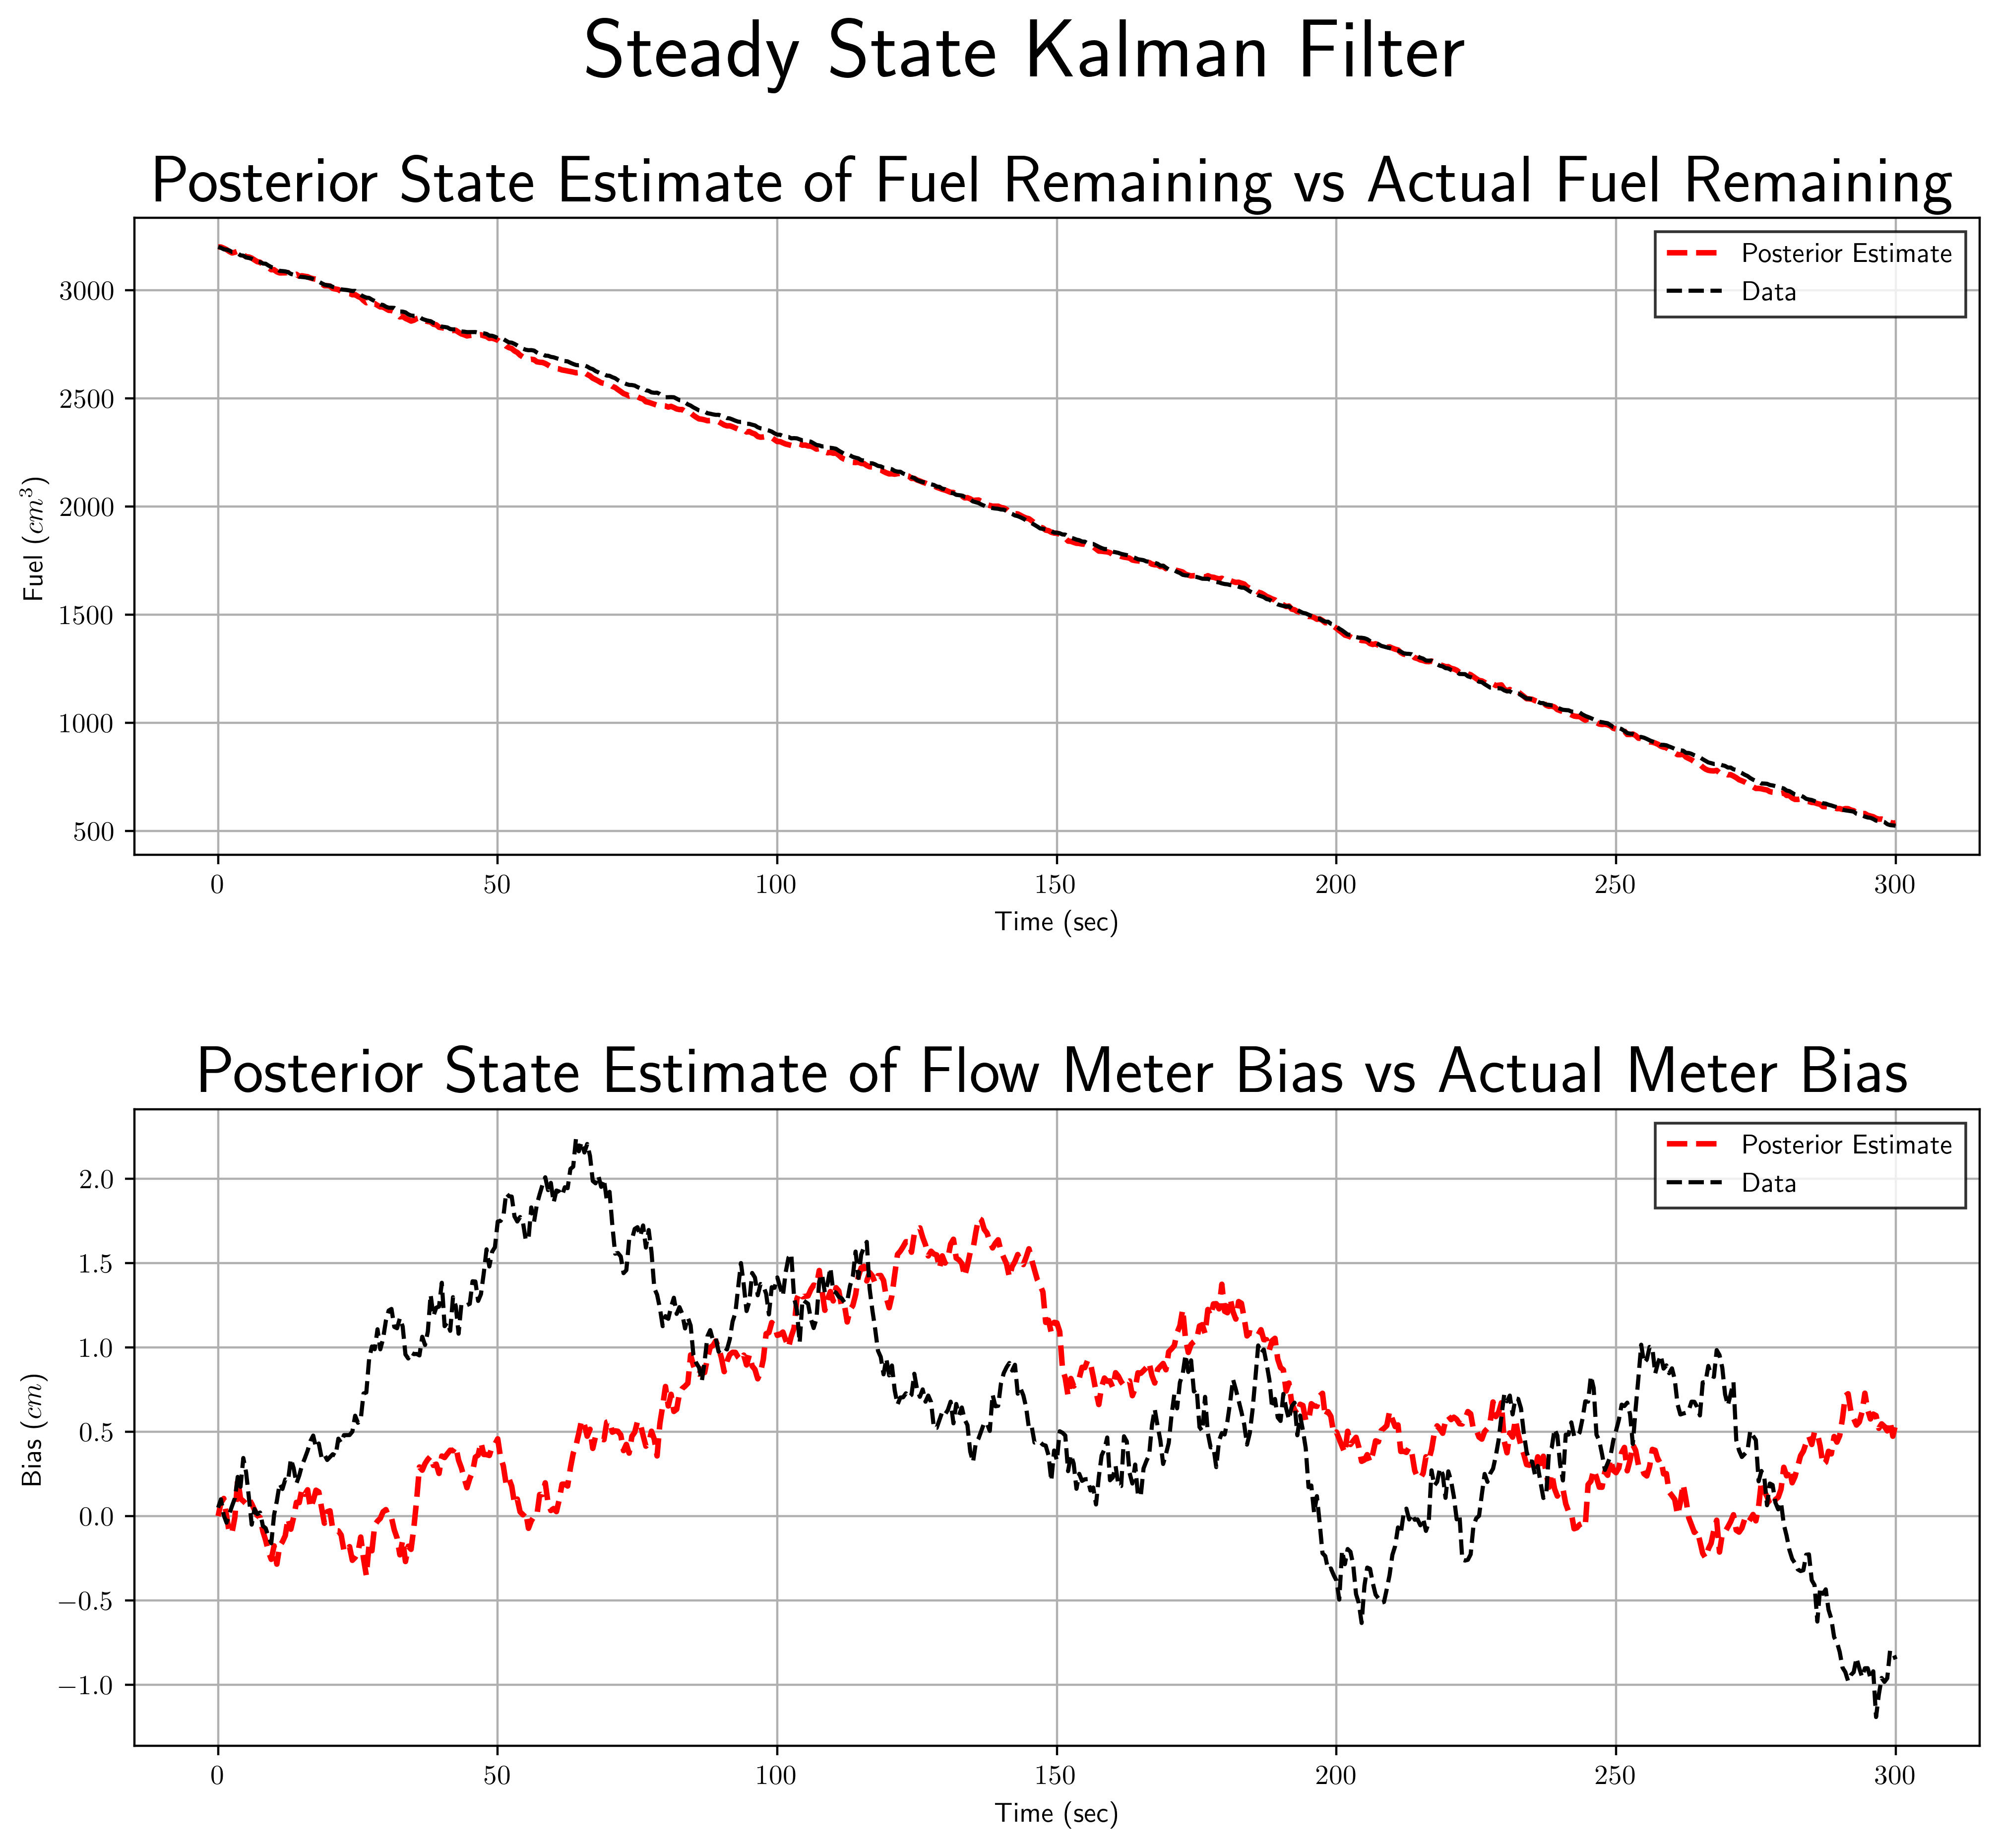

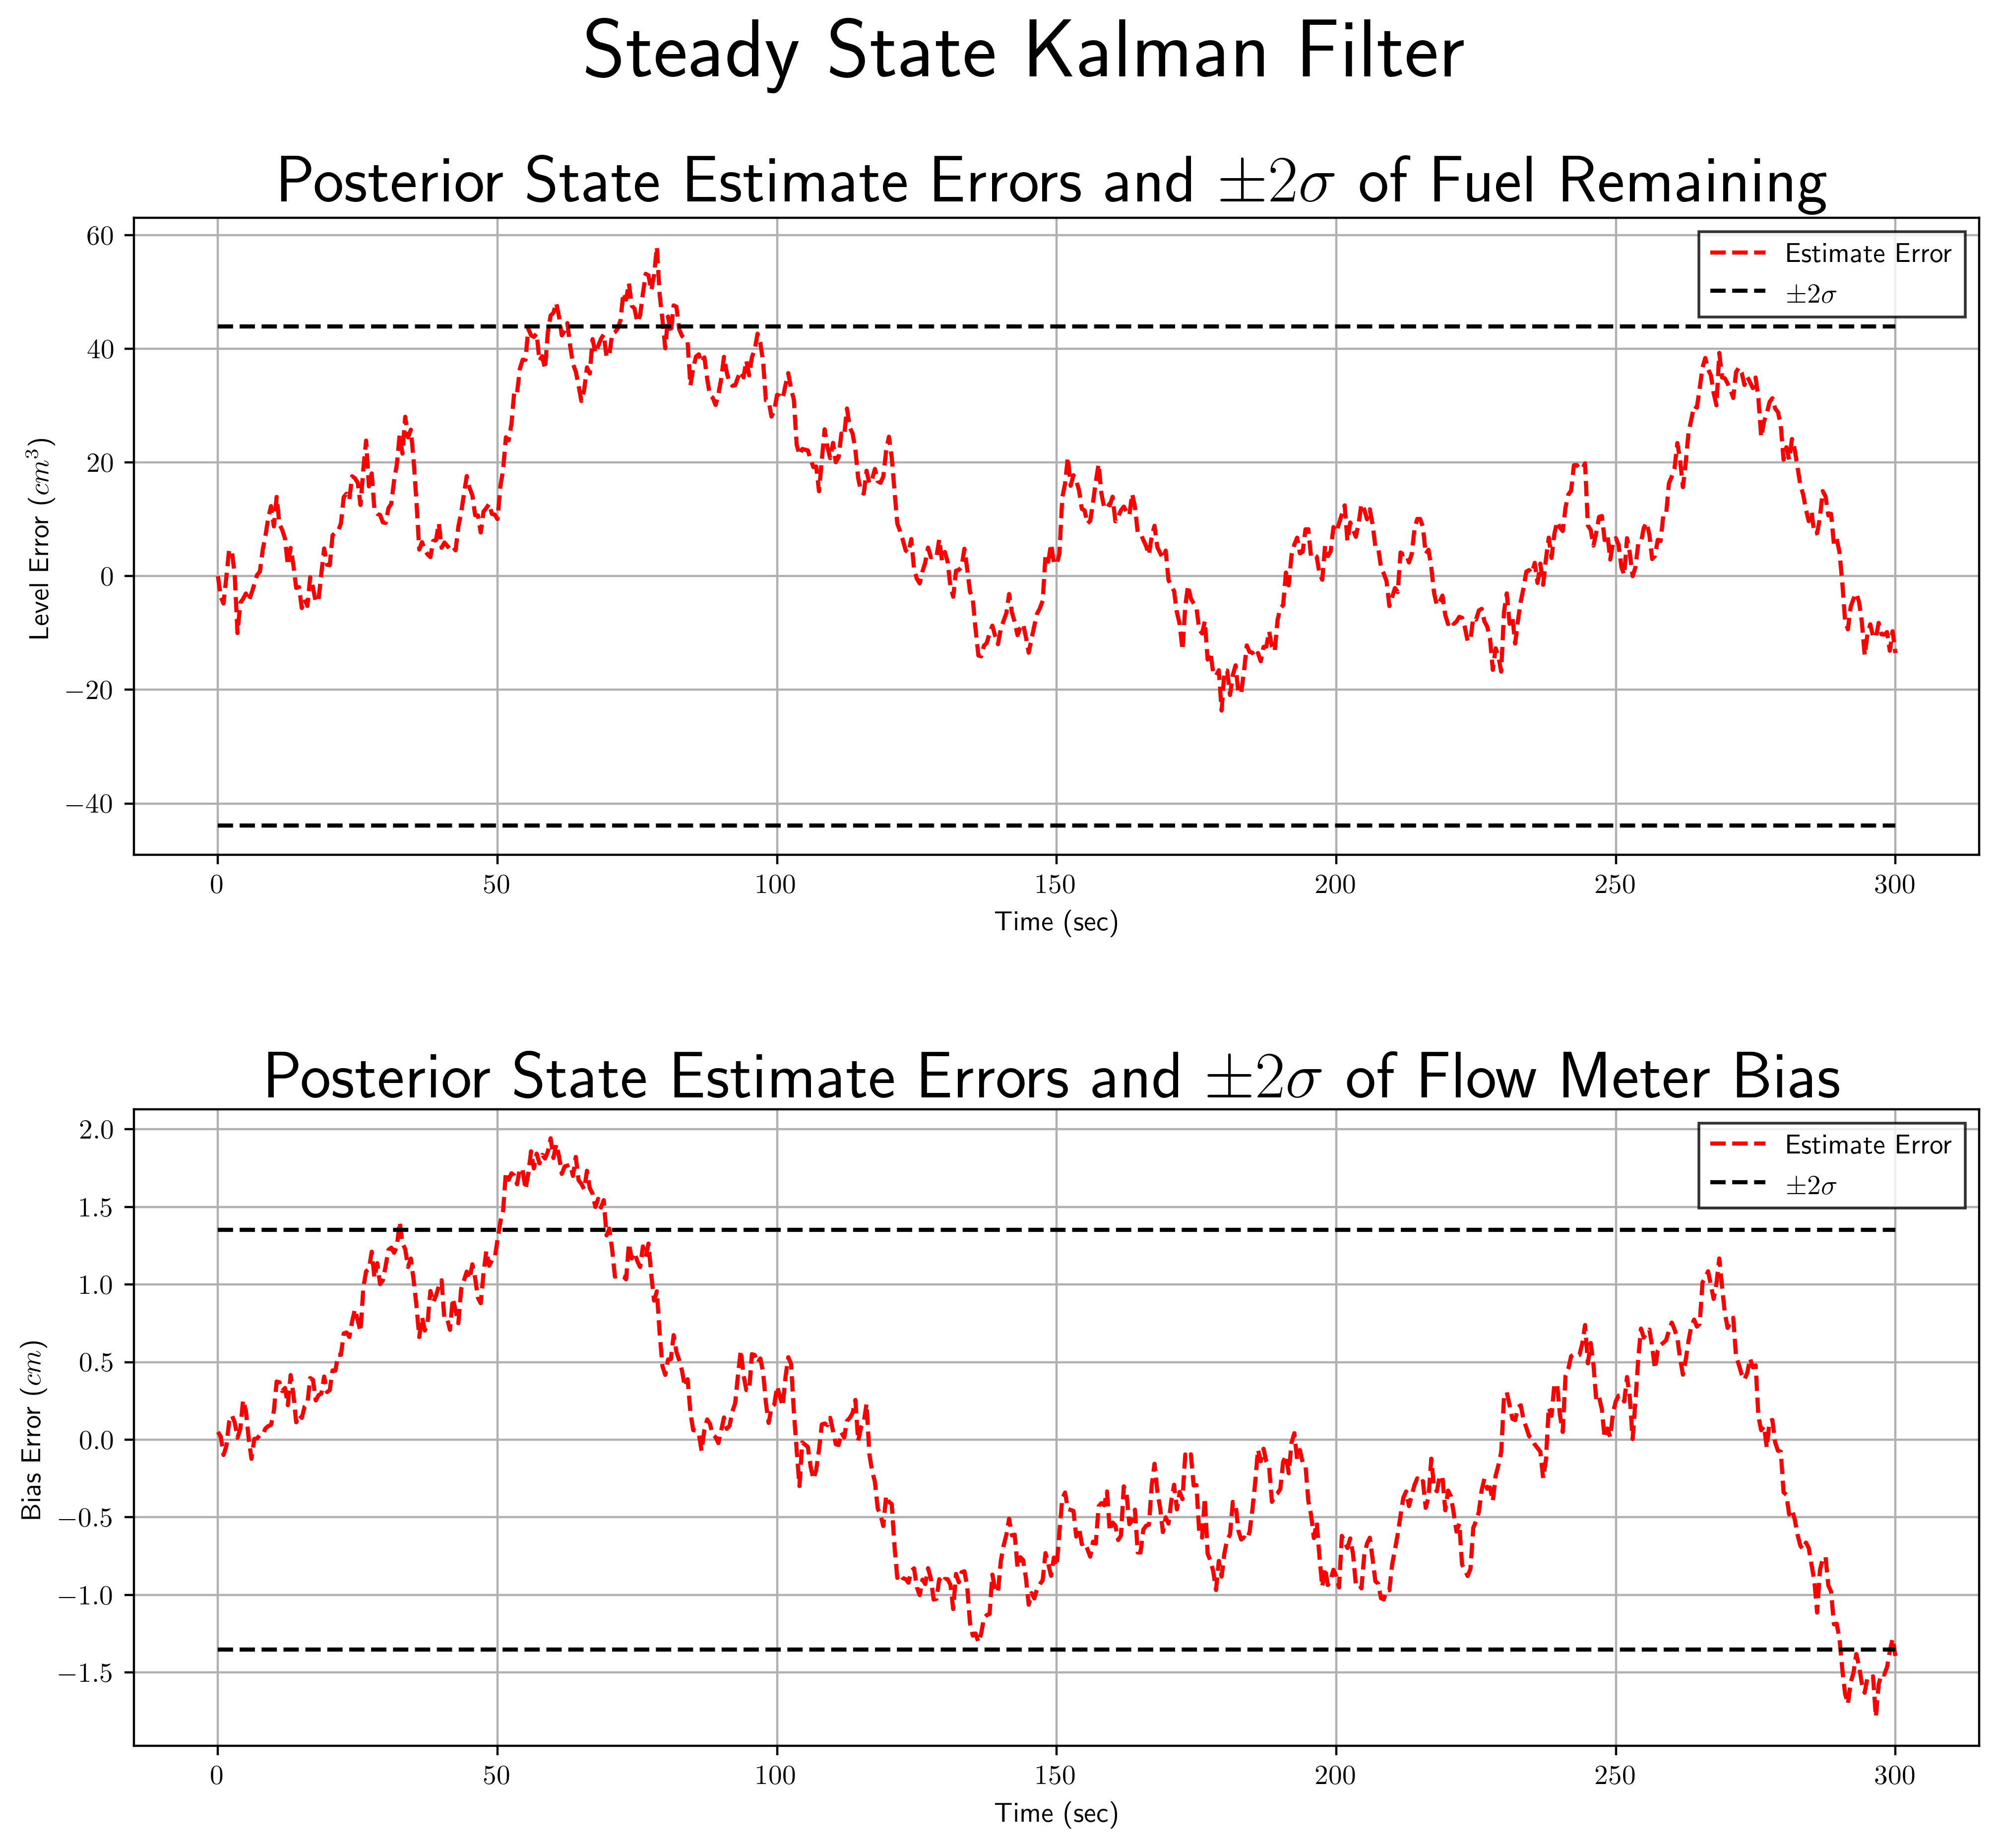

In [334]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle('Steady State Kalman Filter',fontsize=30)
ax1.set_title(
    "Posterior State Estimate of Fuel Remaining vs Actual Fuel Remaining", fontsize=24
)
ax1.plot(t, res_a[:, 0], "r--", lw=2, label="Posterior Estimate")
ax1.plot(t, df["f_k"], "k--", label="Data")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Fuel ($cm^3$)")
leg = ax1.legend(fancybox=False)

ax2.set_title(
    "Posterior State Estimate of Flow Meter Bias vs Actual Meter Bias", fontsize=24
)
ax2.plot(t, res_a[:, 1], "r--", lw=2, label="Posterior Estimate")
ax2.plot(t, df["b_k"], "k--", label="Data")
ax2.grid()
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias ($cm$)")
ax2.legend(fancybox=False)
plt.subplots_adjust(hspace=0.4)
plt.savefig("1a.png")


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=400)
fig.suptitle('Steady State Kalman Filter',fontsize=30)
diffs = df[["f_k", "b_k"]].to_numpy() - res_a
ax1.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Fuel Remaining", fontsize=24
)
ax1.plot(t, diffs[:, 0], "r--", label="Estimate Error")
ax1.plot(t, np.repeat(2 * np.sqrt(P_inf[0, 0]),601), "k--", label="$\pm 2\sigma$")
ax1.plot(t, np.repeat(-2 * np.sqrt(P_inf[0, 0]),601), "k--")
ax1.grid()
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Level Error ($cm^3$)")
ax1.legend(fancybox=False)


ax2.set_title(
    "Posterior State Estimate Errors and $\pm 2\sigma$ of Flow Meter Bias", fontsize=24
)
ax2.plot(t, diffs[:, 1], "r--", label="Estimate Error")
ax2.plot(t, np.repeat(2 * np.sqrt(P_inf[1, 1]), 601), "k--", label="$\pm 2\sigma$")
ax2.plot(t, np.repeat(-2 * np.sqrt(P_inf[1, 1]),601), "k--")
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Bias Error ($cm$)")
ax2.grid()
plt.subplots_adjust(hspace=0.4)
ax2.legend(fancybox=False)
plt.savefig("1b.png")